In [1]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow

In [2]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

[2023-05-18 10:22:19] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-18 10:22:30] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-18 10:22:30] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-18 10:22:30] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-18 10:22:30] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-05-18 10:22:32] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [3]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l, 
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [5]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [6]:

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3WnZDr6Mvsr7ASpMwNWJ")
project = rf.workspace("roboflow-gw7yv").project("vehicles-openimages")
dataset = project.version(1).download("yolov8")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics<=8.0.20`, to intall it `pip install ultralytics<=8.0.20`.


Extracting Dataset Version Zip to Vehicles-OpenImages-1 in yolov8:: 100%|██████████| 2520/2520 [00:00<00:00, 3737.74it/s]


In [9]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [7]:
dataset_params = {
    'data_dir':'/content/Vehicles-OpenImages-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
}

In [10]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()


Caching annotations: 100%|██████████| 126/126 [00:00<00:00, 4621.54it/s]


In [11]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

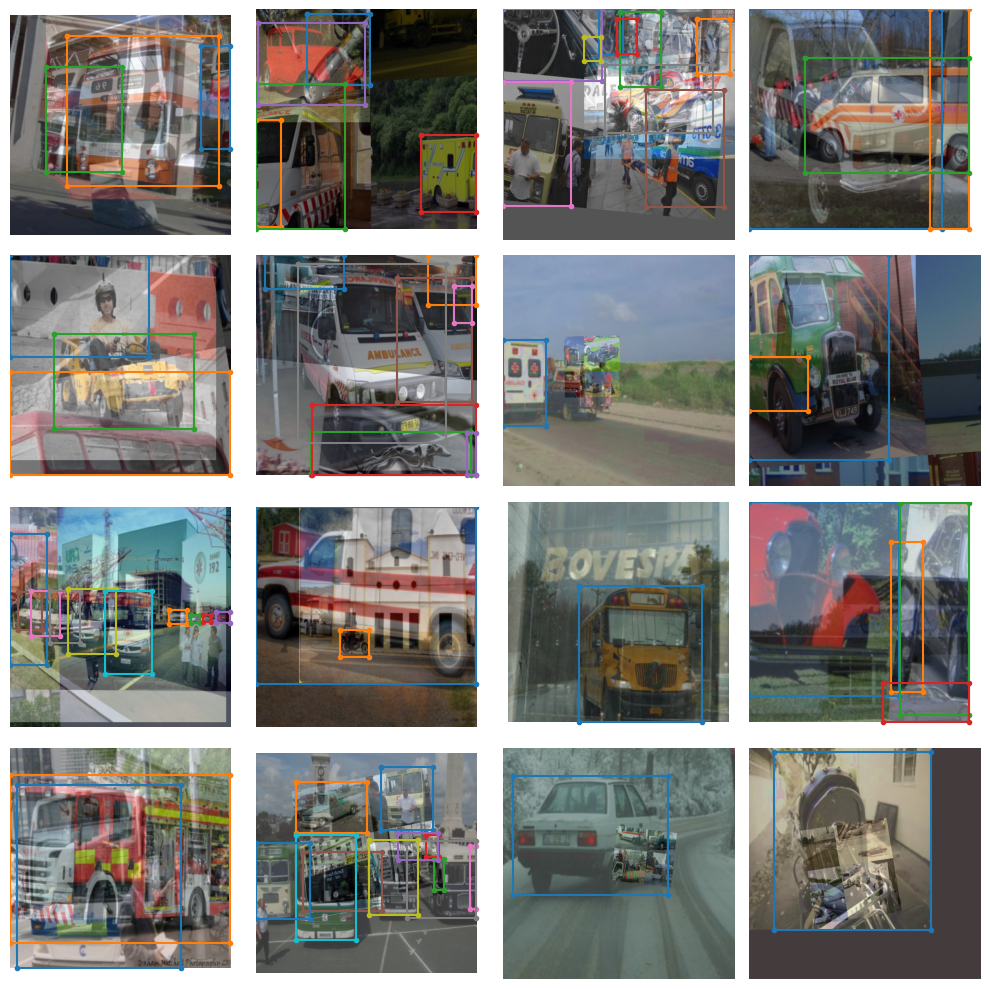

In [12]:
train_data.dataset.plot()

In [13]:
from super_gradients.training import models
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-05-18 10:25:56] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [14]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [15]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-18 10:26:13] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-05-18 10:26:18] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to checkpoints/my_first_yolonas_run/console_May18_10_26_18.txt


[2023-05-18 10:26:25] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 878        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         54         (len(train_loader))
    - Gradient updates per epoch:   54         (len(train_loader) / batch_accumulate)

[2023-05-18 10:28:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-05-18 10:28:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.05087576061487198
[2023-05-18 10:29:45] INFO - base_sg_logger.py - Checkpoint saved in ch

SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 2.1958
│   │   ├── Best until now = 2.2186 (↘ -0.0228)
│   │   └── Epoch N-1      = 2.2186 (↘ -0.0228)
│   ├── Ppyoloeloss/loss_cls = 1.1388
│   │   ├── Best until now = 1.1415 (↘ -0.0027)
│   │   └── Epoch N-1      = 1.1415 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 1.2288
│   │   ├── Best until now = 1.2443 (↘ -0.0154)
│   │   └── Epoch N-1      = 1.2443 (↘ -0.0154)
│   └── Ppyoloeloss/loss_iou = 0.177
│       ├── Best until now = 0.182  (↘ -0.0049)
│       └── Epoch N-1      = 0.182  (↘ -0.0049)
└── Validation
    ├── F1@0.50 = 0.109
    │   ├── Best until now = 0.0533 (↗ 0.0556)
    │   └── Epoch N-1      = 0.0533 (↗ 0.0556)
    ├── Map@0.50 = 0.537
    │   ├── Best until now = 0.5944 (↘ -0.0574)
    │   └── Epoch N-1      = 0.5944 (↘ -0.0574)
    ├── Ppyoloeloss/loss = 2.0594
    │   ├── Best until now = 2.0342 (↗ 0.0252)
    │   └── Epoch N-1      = 2.0342 (↗ 0.0252)
    ├── Ppyoloeloss/loss_cls = 1.1804
    │   ├── Best

In [16]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

[2023-05-18 10:50:50] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/my_first_yolonas_run/average_model.pth EMA checkpoint.


In [17]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


{'PPYoloELoss/loss_cls': 0.96881694,
 'PPYoloELoss/loss_iou': 0.16557263,
 'PPYoloELoss/loss_dfl': 1.1352842,
 'PPYoloELoss/loss': 1.9503906,
 'Precision@0.50': tensor(0.0293),
 'Recall@0.50': tensor(0.9508),
 'mAP@0.50': tensor(0.7147),
 'F1@0.50': tensor(0.0568)}

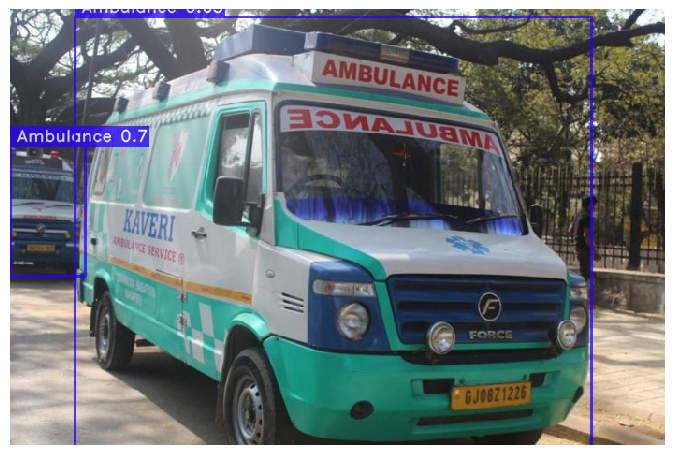

In [26]:
img_url = '/content/testing2.jpg'
best_model.predict(img_url).show()

**This Research paper and Nicolai Høirup Nielsen helped us a lot to make this model ready:
https://www.researchgate.net/publication/364044166_Real-Time_Vehicle_Detection_Based_on_Improved_YOLO_v5**

**Nicolai Høirup Nielsen: https://github.com/niconielsen32**
